Sources
---
- Implementation: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- GPU Speedup   : https://towardsdatascience.com/speed-up-your-algorithms-part-1-pytorch-56d8a4ae7051

Import necessary libraries:
---

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

Preprocess the data:
---

In [4]:
transform   = transforms.Compose(
              [transforms.ToTensor(),
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset    = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset     = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader  = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes     = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


Preview attached images:
---

truck horse  deer  deer


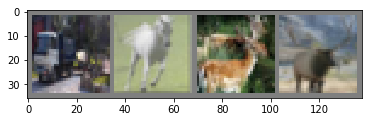

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Necessary to actually see the images
%matplotlib inline 

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Define a CNN architecture to process Cifar-10:
---

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 5)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 16, 5)
        self.fc1   = nn.Linear(16 * 5 * 5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))).cuda()
        x = self.pool(F.relu(self.conv2(x))).cuda()
        x = x.view(-1, 16 * 5 * 5).cuda()
        x = F.relu(self.fc1(x)).cuda()
        x = F.relu(self.fc2(x)).cuda()
        x = self.fc3(x).cuda()
        return x

# Create the network and send it to the GPU
net       = Net().cuda()
print("Cuda available? " + str(next(net.parameters()).is_cuda))

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Cuda available? True


Actually train the network:
---
In order to actually make the network utilize the GPU, the X.to(device) functions as well as X.cuda() are utilized.

In [8]:
 for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).cuda()
        loss    = criterion(outputs, labels).cuda()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

AttributeError: 'DataLoader' object has no attribute 'to'

After training, test the network:
---

GroundTruth:    cat  ship  ship plane
Predicted:    dog truck truck   dog


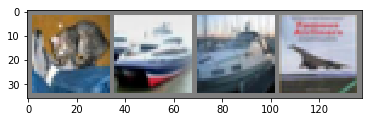

In [35]:
dataiter       = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Show prediction
outputs      = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Let's see the accuracy overall:
---

In [6]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

RuntimeError: Expected object of type torch.cuda.LongTensor but found type torch.LongTensor for argument #2 'other'

To continue experiments, let's flush the GPU's CUDA allocated memory:
---

In [7]:
torch.cuda.empty_cache()

Parallel Data Loader for PyTorch
---
- Source: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

Now, let's change a bit about PyTorch's example Cifar-10 implementation.
---
GPU Utilization with the above implementation caps at around 4-7% on an EVGA GTX 980 SC.

Modified Preprocessing:
---
Previously, the PyTorch implementation handled sending images to the GPU in mini-batches of 4 images at a time. This stresses overhead communication between the CPU and GPU, forcing the CPU to ~60% while the GPU was barely breaching 6% utilization. First, instead of sending minibatches to the GPU, I'll modify PyTorch's example to actually send an entire batch at a time, and have the second batch preprocessed to eliminate GPU I/O waiting.

Changes: number of worker threads increased from 2 to 6, and batch size increased from 4 to 128.

In [7]:
transform   = transforms.Compose(
              [transforms.ToTensor(),
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Training data split
trainset    = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

# Testing data split
testset     = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader  = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Modified training:
---

In [ ]:
import time
max_epochs         = 10000
running_loss       = 0.0
preprocessing_time = 0. 
processing_time    = 0.
i                  = 0
prInterval         = 10
all_losses         = []

start = 0
stop  = 0

# Loop over epochs
beginning = 0
end       = 0
for epoch in range(max_epochs):
    # Training
    end = time.time()
    if(epoch > 0):
        print("Interval between epoch: %3.3fs"% float(end - beginning))
    beginning = time.time()
    
    for local_batch, local_labels in trainloader:
        start = time.time()
        # Transfer to GPU
        inputs, labels = local_batch.to(device), local_labels.to(device)
        
        stop  = time.time()
        preprocessing_time += stop - start
        start = time.time()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).cuda()
        loss    = criterion(outputs, labels).cuda()
        loss.backward()
        optimizer.step()
        
        #del inputs, labels

        # print statistics
        running_loss += loss.item()
        i += 1
        
        stop = time.time()
        processing_time += stop - start
        
        if i % prInterval == prInterval - 1:    # print every 2000 mini-batches
            print('[ %.1fs][%3d, %5d] loss: %.3f , compute time %.3f, preprocessing time %.3f\n' %
                  (stop - beginning, epoch + 1, i + 1, running_loss / prInterval, processing_time, preprocessing_time) )
            all_losses.append(running_loss / prInterval)
            running_loss = 0.0
            preprocessing_time = 0
            processing_time = 0

[ 4.0s][  1,    10] loss: 2.074 , compute time 1.063, preprocessing time 0.027

[ 4.5s][  1,    20] loss: 2.303 , compute time 0.365, preprocessing time 0.032

[ 4.9s][  1,    30] loss: 2.302 , compute time 0.361, preprocessing time 0.031

[ 5.3s][  1,    40] loss: 2.303 , compute time 0.361, preprocessing time 0.031

[ 5.7s][  1,    50] loss: 2.303 , compute time 0.365, preprocessing time 0.035

[ 6.1s][  1,    60] loss: 2.302 , compute time 0.366, preprocessing time 0.034

[ 6.5s][  1,    70] loss: 2.302 , compute time 0.357, preprocessing time 0.031

[ 6.9s][  1,    80] loss: 2.302 , compute time 0.357, preprocessing time 0.029

[ 7.3s][  1,    90] loss: 2.303 , compute time 0.360, preprocessing time 0.029

Interval between epoch: 7.646s
[ 3.0s][  2,   100] loss: 2.301 , compute time 0.354, preprocessing time 0.027

[ 3.4s][  2,   110] loss: 2.300 , compute time 0.371, preprocessing time 0.032

[ 3.8s][  2,   120] loss: 2.299 , compute time 0.369, preprocessing time 0.031

[ 4.2s][ 


[ 4.4s][ 11,  1000] loss: 1.803 , compute time 0.361, preprocessing time 0.028

[ 4.8s][ 11,  1010] loss: 1.812 , compute time 0.360, preprocessing time 0.030

[ 5.2s][ 11,  1020] loss: 1.817 , compute time 0.360, preprocessing time 0.031

[ 5.6s][ 11,  1030] loss: 1.806 , compute time 0.359, preprocessing time 0.033

[ 6.0s][ 11,  1040] loss: 1.802 , compute time 0.359, preprocessing time 0.029

[ 6.4s][ 11,  1050] loss: 1.810 , compute time 0.358, preprocessing time 0.030

[ 6.8s][ 11,  1060] loss: 1.806 , compute time 0.359, preprocessing time 0.029

[ 7.2s][ 11,  1070] loss: 1.782 , compute time 0.359, preprocessing time 0.031

Interval between epoch: 7.557s
[ 3.5s][ 12,  1080] loss: 1.782 , compute time 0.350, preprocessing time 0.030

[ 3.9s][ 12,  1090] loss: 1.795 , compute time 0.367, preprocessing time 0.030

[ 4.3s][ 12,  1100] loss: 1.795 , compute time 0.361, preprocessing time 0.027

[ 4.7s][ 12,  1110] loss: 1.782 , compute time 0.361, preprocessing time 0.032

[ 5.1s][


[ 4.4s][ 21,  1990] loss: 1.548 , compute time 0.371, preprocessing time 0.030

[ 4.8s][ 21,  2000] loss: 1.555 , compute time 0.375, preprocessing time 0.032

[ 5.3s][ 21,  2010] loss: 1.545 , compute time 0.380, preprocessing time 0.031

[ 5.7s][ 21,  2020] loss: 1.530 , compute time 0.378, preprocessing time 0.033

[ 6.1s][ 21,  2030] loss: 1.533 , compute time 0.378, preprocessing time 0.034

[ 6.5s][ 21,  2040] loss: 1.519 , compute time 0.380, preprocessing time 0.032

[ 7.0s][ 21,  2050] loss: 1.524 , compute time 0.378, preprocessing time 0.031

Interval between epoch: 7.330s
[ 3.2s][ 22,  2060] loss: 1.505 , compute time 0.367, preprocessing time 0.029

[ 3.6s][ 22,  2070] loss: 1.529 , compute time 0.371, preprocessing time 0.031

[ 4.0s][ 22,  2080] loss: 1.499 , compute time 0.366, preprocessing time 0.031

[ 4.4s][ 22,  2090] loss: 1.526 , compute time 0.373, preprocessing time 0.031

[ 4.8s][ 22,  2100] loss: 1.523 , compute time 0.379, preprocessing time 0.030

[ 5.3s][


[ 5.7s][ 31,  2980] loss: 1.352 , compute time 0.380, preprocessing time 0.032

[ 6.1s][ 31,  2990] loss: 1.385 , compute time 0.378, preprocessing time 0.029

[ 6.6s][ 31,  3000] loss: 1.381 , compute time 0.381, preprocessing time 0.031

[ 7.0s][ 31,  3010] loss: 1.359 , compute time 0.380, preprocessing time 0.030

[ 7.4s][ 31,  3020] loss: 1.388 , compute time 0.380, preprocessing time 0.034

[ 7.8s][ 31,  3030] loss: 1.378 , compute time 0.381, preprocessing time 0.031

Interval between epoch: 8.194s
[ 3.6s][ 32,  3040] loss: 1.363 , compute time 0.368, preprocessing time 0.030

[ 4.0s][ 32,  3050] loss: 1.383 , compute time 0.372, preprocessing time 0.032

[ 4.4s][ 32,  3060] loss: 1.378 , compute time 0.371, preprocessing time 0.031

[ 4.8s][ 32,  3070] loss: 1.367 , compute time 0.380, preprocessing time 0.031

[ 5.3s][ 32,  3080] loss: 1.378 , compute time 0.378, preprocessing time 0.031

[ 5.7s][ 32,  3090] loss: 1.373 , compute time 0.381, preprocessing time 0.029

[ 6.1s][


[ 6.3s][ 41,  3970] loss: 1.278 , compute time 0.381, preprocessing time 0.032

[ 6.7s][ 41,  3980] loss: 1.274 , compute time 0.379, preprocessing time 0.030

[ 7.1s][ 41,  3990] loss: 1.272 , compute time 0.379, preprocessing time 0.032

[ 7.6s][ 41,  4000] loss: 1.276 , compute time 0.384, preprocessing time 0.032

[ 8.0s][ 41,  4010] loss: 1.282 , compute time 0.381, preprocessing time 0.031

Interval between epoch: 8.361s
[ 4.0s][ 42,  4020] loss: 1.248 , compute time 0.367, preprocessing time 0.031

[ 4.5s][ 42,  4030] loss: 1.279 , compute time 0.369, preprocessing time 0.030

[ 4.9s][ 42,  4040] loss: 1.254 , compute time 0.363, preprocessing time 0.032

[ 5.3s][ 42,  4050] loss: 1.257 , compute time 0.374, preprocessing time 0.033

[ 5.7s][ 42,  4060] loss: 1.279 , compute time 0.380, preprocessing time 0.031

[ 6.1s][ 42,  4070] loss: 1.258 , compute time 0.383, preprocessing time 0.035

[ 6.6s][ 42,  4080] loss: 1.283 , compute time 0.385, preprocessing time 0.036

[ 7.0s][


[ 5.8s][ 51,  4960] loss: 1.174 , compute time 0.380, preprocessing time 0.031

[ 6.2s][ 51,  4970] loss: 1.160 , compute time 0.379, preprocessing time 0.029

[ 6.6s][ 51,  4980] loss: 1.160 , compute time 0.378, preprocessing time 0.029

[ 7.0s][ 51,  4990] loss: 1.182 , compute time 0.381, preprocessing time 0.032

Interval between epoch: 7.406s
[ 4.2s][ 52,  5000] loss: 1.168 , compute time 0.368, preprocessing time 0.027

[ 4.6s][ 52,  5010] loss: 1.164 , compute time 0.368, preprocessing time 0.031

[ 5.0s][ 52,  5020] loss: 1.186 , compute time 0.363, preprocessing time 0.032

[ 5.4s][ 52,  5030] loss: 1.164 , compute time 0.371, preprocessing time 0.029

[ 5.8s][ 52,  5040] loss: 1.175 , compute time 0.377, preprocessing time 0.036

[ 6.3s][ 52,  5050] loss: 1.162 , compute time 0.382, preprocessing time 0.033

[ 6.7s][ 52,  5060] loss: 1.166 , compute time 0.385, preprocessing time 0.035

[ 7.1s][ 52,  5070] loss: 1.148 , compute time 0.381, preprocessing time 0.033

[ 7.6s][


[ 6.2s][ 61,  5950] loss: 1.100 , compute time 0.383, preprocessing time 0.035

[ 6.6s][ 61,  5960] loss: 1.110 , compute time 0.382, preprocessing time 0.034

[ 7.0s][ 61,  5970] loss: 1.111 , compute time 0.382, preprocessing time 0.032

Interval between epoch: 7.420s
[ 3.2s][ 62,  5980] loss: 1.098 , compute time 0.369, preprocessing time 0.031

[ 3.6s][ 62,  5990] loss: 1.094 , compute time 0.375, preprocessing time 0.027

[ 4.0s][ 62,  6000] loss: 1.090 , compute time 0.381, preprocessing time 0.032

[ 4.5s][ 62,  6010] loss: 1.077 , compute time 0.383, preprocessing time 0.031

[ 4.9s][ 62,  6020] loss: 1.090 , compute time 0.383, preprocessing time 0.032

[ 5.3s][ 62,  6030] loss: 1.068 , compute time 0.383, preprocessing time 0.033

[ 5.7s][ 62,  6040] loss: 1.123 , compute time 0.382, preprocessing time 0.030

[ 6.2s][ 62,  6050] loss: 1.090 , compute time 0.381, preprocessing time 0.032

[ 6.6s][ 62,  6060] loss: 1.081 , compute time 0.382, preprocessing time 0.033

[ 7.0s][


[ 6.8s][ 71,  6940] loss: 1.061 , compute time 0.380, preprocessing time 0.032

[ 7.2s][ 71,  6950] loss: 1.053 , compute time 0.382, preprocessing time 0.032

Interval between epoch: 7.610s
[ 3.7s][ 72,  6960] loss: 1.046 , compute time 0.369, preprocessing time 0.031

[ 4.1s][ 72,  6970] loss: 1.023 , compute time 0.373, preprocessing time 0.031

[ 4.5s][ 72,  6980] loss: 0.996 , compute time 0.367, preprocessing time 0.030

[ 5.0s][ 72,  6990] loss: 1.056 , compute time 0.376, preprocessing time 0.029

[ 5.4s][ 72,  7000] loss: 1.004 , compute time 0.380, preprocessing time 0.033

[ 5.8s][ 72,  7010] loss: 1.017 , compute time 0.380, preprocessing time 0.030

[ 6.2s][ 72,  7020] loss: 1.047 , compute time 0.381, preprocessing time 0.030

[ 6.6s][ 72,  7030] loss: 1.023 , compute time 0.382, preprocessing time 0.030

[ 7.1s][ 72,  7040] loss: 1.028 , compute time 0.383, preprocessing time 0.036

[ 7.5s][ 72,  7050] loss: 1.033 , compute time 0.380, preprocessing time 0.030

Interval


[ 7.3s][ 81,  7930] loss: 0.968 , compute time 0.379, preprocessing time 0.032

Interval between epoch: 7.685s
[ 3.4s][ 82,  7940] loss: 0.959 , compute time 0.368, preprocessing time 0.029

[ 3.8s][ 82,  7950] loss: 0.976 , compute time 0.375, preprocessing time 0.030

[ 4.2s][ 82,  7960] loss: 0.980 , compute time 0.378, preprocessing time 0.029

[ 4.6s][ 82,  7970] loss: 0.997 , compute time 0.380, preprocessing time 0.030

[ 5.0s][ 82,  7980] loss: 0.970 , compute time 0.380, preprocessing time 0.033

[ 5.5s][ 82,  7990] loss: 0.962 , compute time 0.381, preprocessing time 0.030

[ 5.9s][ 82,  8000] loss: 0.989 , compute time 0.380, preprocessing time 0.031

[ 6.3s][ 82,  8010] loss: 0.977 , compute time 0.381, preprocessing time 0.031

[ 6.7s][ 82,  8020] loss: 0.976 , compute time 0.380, preprocessing time 0.031

[ 7.2s][ 82,  8030] loss: 0.970 , compute time 0.382, preprocessing time 0.031

Interval between epoch: 7.458s
[ 3.6s][ 83,  8040] loss: 0.981 , compute time 0.367, pre


Interval between epoch: 7.241s
[ 3.6s][ 92,  8920] loss: 0.928 , compute time 0.368, preprocessing time 0.029

[ 4.0s][ 92,  8930] loss: 0.922 , compute time 0.376, preprocessing time 0.031

[ 4.4s][ 92,  8940] loss: 0.935 , compute time 0.377, preprocessing time 0.032

[ 4.8s][ 92,  8950] loss: 0.927 , compute time 0.380, preprocessing time 0.032

[ 5.3s][ 92,  8960] loss: 0.946 , compute time 0.378, preprocessing time 0.030

[ 5.7s][ 92,  8970] loss: 0.953 , compute time 0.381, preprocessing time 0.030

[ 6.1s][ 92,  8980] loss: 0.921 , compute time 0.380, preprocessing time 0.030

[ 6.5s][ 92,  8990] loss: 0.917 , compute time 0.380, preprocessing time 0.030

[ 7.0s][ 92,  9000] loss: 0.952 , compute time 0.379, preprocessing time 0.031

[ 7.4s][ 92,  9010] loss: 0.948 , compute time 0.381, preprocessing time 0.030

Interval between epoch: 7.660s
[ 3.5s][ 93,  9020] loss: 0.928 , compute time 0.369, preprocessing time 0.027

[ 4.0s][ 93,  9030] loss: 0.922 , compute time 0.372, pre


[ 4.2s][102,  9910] loss: 0.886 , compute time 0.371, preprocessing time 0.032

[ 4.7s][102,  9920] loss: 0.902 , compute time 0.371, preprocessing time 0.032

[ 5.1s][102,  9930] loss: 0.922 , compute time 0.376, preprocessing time 0.032

[ 5.5s][102,  9940] loss: 0.886 , compute time 0.379, preprocessing time 0.030

[ 5.9s][102,  9950] loss: 0.877 , compute time 0.379, preprocessing time 0.031

[ 6.4s][102,  9960] loss: 0.907 , compute time 0.380, preprocessing time 0.031

[ 6.8s][102,  9970] loss: 0.903 , compute time 0.379, preprocessing time 0.032

[ 7.2s][102,  9980] loss: 0.895 , compute time 0.379, preprocessing time 0.030

[ 7.6s][102,  9990] loss: 0.893 , compute time 0.380, preprocessing time 0.030

Interval between epoch: 7.914s
[ 3.2s][103, 10000] loss: 0.896 , compute time 0.368, preprocessing time 0.025

[ 3.6s][103, 10010] loss: 0.875 , compute time 0.375, preprocessing time 0.031

[ 4.0s][103, 10020] loss: 0.859 , compute time 0.378, preprocessing time 0.031

[ 4.5s][


[ 4.0s][112, 10900] loss: 0.863 , compute time 0.381, preprocessing time 0.034

[ 4.4s][112, 10910] loss: 0.842 , compute time 0.381, preprocessing time 0.033

[ 4.9s][112, 10920] loss: 0.866 , compute time 0.381, preprocessing time 0.027

[ 5.3s][112, 10930] loss: 0.841 , compute time 0.380, preprocessing time 0.033

[ 5.7s][112, 10940] loss: 0.888 , compute time 0.379, preprocessing time 0.031

[ 6.1s][112, 10950] loss: 0.884 , compute time 0.380, preprocessing time 0.032

[ 6.6s][112, 10960] loss: 0.862 , compute time 0.382, preprocessing time 0.031

[ 7.0s][112, 10970] loss: 0.859 , compute time 0.381, preprocessing time 0.033

Interval between epoch: 7.290s
[ 3.1s][113, 10980] loss: 0.828 , compute time 0.367, preprocessing time 0.027

[ 3.5s][113, 10990] loss: 0.878 , compute time 0.377, preprocessing time 0.029

[ 3.9s][113, 11000] loss: 0.863 , compute time 0.378, preprocessing time 0.030

[ 4.4s][113, 11010] loss: 0.818 , compute time 0.381, preprocessing time 0.031

[ 4.8s][


[ 4.8s][122, 11890] loss: 0.815 , compute time 0.377, preprocessing time 0.030

[ 5.3s][122, 11900] loss: 0.835 , compute time 0.379, preprocessing time 0.030

[ 5.7s][122, 11910] loss: 0.809 , compute time 0.380, preprocessing time 0.032

[ 6.1s][122, 11920] loss: 0.831 , compute time 0.381, preprocessing time 0.030

[ 6.5s][122, 11930] loss: 0.829 , compute time 0.381, preprocessing time 0.029

[ 7.0s][122, 11940] loss: 0.821 , compute time 0.382, preprocessing time 0.034

[ 7.4s][122, 11950] loss: 0.792 , compute time 0.384, preprocessing time 0.034

Interval between epoch: 7.689s
[ 3.2s][123, 11960] loss: 0.844 , compute time 0.369, preprocessing time 0.031

[ 3.6s][123, 11970] loss: 0.825 , compute time 0.375, preprocessing time 0.030

[ 4.0s][123, 11980] loss: 0.815 , compute time 0.379, preprocessing time 0.031

[ 4.4s][123, 11990] loss: 0.833 , compute time 0.380, preprocessing time 0.031

[ 4.9s][123, 12000] loss: 0.804 , compute time 0.380, preprocessing time 0.030

[ 5.3s][


[ 5.1s][132, 12880] loss: 0.781 , compute time 0.379, preprocessing time 0.031

[ 5.5s][132, 12890] loss: 0.788 , compute time 0.380, preprocessing time 0.030

[ 6.0s][132, 12900] loss: 0.788 , compute time 0.381, preprocessing time 0.029

[ 6.4s][132, 12910] loss: 0.798 , compute time 0.380, preprocessing time 0.032

[ 6.8s][132, 12920] loss: 0.794 , compute time 0.380, preprocessing time 0.033

[ 7.2s][132, 12930] loss: 0.789 , compute time 0.382, preprocessing time 0.030

Interval between epoch: 7.516s
[ 3.2s][133, 12940] loss: 0.812 , compute time 0.368, preprocessing time 0.028

[ 3.6s][133, 12950] loss: 0.792 , compute time 0.374, preprocessing time 0.029

[ 4.1s][133, 12960] loss: 0.803 , compute time 0.377, preprocessing time 0.028

[ 4.5s][133, 12970] loss: 0.793 , compute time 0.382, preprocessing time 0.032

[ 4.9s][133, 12980] loss: 0.794 , compute time 0.381, preprocessing time 0.033

[ 5.3s][133, 12990] loss: 0.791 , compute time 0.382, preprocessing time 0.032

[ 5.8s][


[ 5.4s][142, 13870] loss: 0.747 , compute time 0.379, preprocessing time 0.033

[ 5.8s][142, 13880] loss: 0.757 , compute time 0.380, preprocessing time 0.033

[ 6.2s][142, 13890] loss: 0.761 , compute time 0.383, preprocessing time 0.034

[ 6.7s][142, 13900] loss: 0.774 , compute time 0.383, preprocessing time 0.033

[ 7.1s][142, 13910] loss: 0.772 , compute time 0.382, preprocessing time 0.036

Interval between epoch: 7.402s
[ 3.3s][143, 13920] loss: 0.760 , compute time 0.370, preprocessing time 0.031

[ 3.7s][143, 13930] loss: 0.781 , compute time 0.371, preprocessing time 0.030

[ 4.2s][143, 13940] loss: 0.748 , compute time 0.378, preprocessing time 0.033

[ 4.6s][143, 13950] loss: 0.775 , compute time 0.379, preprocessing time 0.031

[ 5.0s][143, 13960] loss: 0.753 , compute time 0.380, preprocessing time 0.034

[ 5.4s][143, 13970] loss: 0.784 , compute time 0.380, preprocessing time 0.029

[ 5.9s][143, 13980] loss: 0.772 , compute time 0.378, preprocessing time 0.032

[ 6.3s][


[ 5.9s][152, 14860] loss: 0.731 , compute time 0.382, preprocessing time 0.030

[ 6.3s][152, 14870] loss: 0.735 , compute time 0.384, preprocessing time 0.039

[ 6.7s][152, 14880] loss: 0.739 , compute time 0.386, preprocessing time 0.036

[ 7.2s][152, 14890] loss: 0.740 , compute time 0.383, preprocessing time 0.048

Interval between epoch: 7.476s
[ 4.9s][153, 14900] loss: 0.746 , compute time 0.371, preprocessing time 0.032

[ 5.3s][153, 14910] loss: 0.756 , compute time 0.366, preprocessing time 0.032

[ 5.7s][153, 14920] loss: 0.744 , compute time 0.365, preprocessing time 0.033

[ 6.1s][153, 14930] loss: 0.772 , compute time 0.373, preprocessing time 0.032

[ 6.6s][153, 14940] loss: 0.735 , compute time 0.380, preprocessing time 0.032

[ 7.0s][153, 14950] loss: 0.734 , compute time 0.379, preprocessing time 0.032

[ 7.4s][153, 14960] loss: 0.715 , compute time 0.381, preprocessing time 0.033

[ 7.8s][153, 14970] loss: 0.712 , compute time 0.381, preprocessing time 0.030

[ 8.3s][


[ 6.5s][162, 15850] loss: 0.720 , compute time 0.379, preprocessing time 0.032

[ 6.9s][162, 15860] loss: 0.720 , compute time 0.379, preprocessing time 0.031

[ 7.3s][162, 15870] loss: 0.715 , compute time 0.381, preprocessing time 0.031

Interval between epoch: 7.622s
[ 3.3s][163, 15880] loss: 0.702 , compute time 0.368, preprocessing time 0.028

[ 3.7s][163, 15890] loss: 0.686 , compute time 0.375, preprocessing time 0.031

[ 4.2s][163, 15900] loss: 0.738 , compute time 0.380, preprocessing time 0.028

[ 4.6s][163, 15910] loss: 0.710 , compute time 0.380, preprocessing time 0.031

[ 5.0s][163, 15920] loss: 0.703 , compute time 0.381, preprocessing time 0.031

[ 5.4s][163, 15930] loss: 0.712 , compute time 0.381, preprocessing time 0.034

[ 5.9s][163, 15940] loss: 0.733 , compute time 0.379, preprocessing time 0.030

[ 6.3s][163, 15950] loss: 0.721 , compute time 0.381, preprocessing time 0.031

[ 6.7s][163, 15960] loss: 0.699 , compute time 0.380, preprocessing time 0.030

[ 7.1s][


[ 6.7s][172, 16840] loss: 0.679 , compute time 0.379, preprocessing time 0.030

[ 7.2s][172, 16850] loss: 0.687 , compute time 0.380, preprocessing time 0.031

Interval between epoch: 7.440s
[ 3.3s][173, 16860] loss: 0.669 , compute time 0.369, preprocessing time 0.029

[ 3.7s][173, 16870] loss: 0.690 , compute time 0.373, preprocessing time 0.033

[ 4.1s][173, 16880] loss: 0.683 , compute time 0.379, preprocessing time 0.031

[ 4.6s][173, 16890] loss: 0.690 , compute time 0.380, preprocessing time 0.032

[ 5.0s][173, 16900] loss: 0.718 , compute time 0.380, preprocessing time 0.031

[ 5.4s][173, 16910] loss: 0.660 , compute time 0.380, preprocessing time 0.031

[ 5.8s][173, 16920] loss: 0.694 , compute time 0.382, preprocessing time 0.029

[ 6.3s][173, 16930] loss: 0.681 , compute time 0.382, preprocessing time 0.034

[ 6.7s][173, 16940] loss: 0.697 , compute time 0.383, preprocessing time 0.031

[ 7.1s][173, 16950] loss: 0.683 , compute time 0.385, preprocessing time 0.033

Interval


[ 7.2s][182, 17830] loss: 0.698 , compute time 0.382, preprocessing time 0.028

Interval between epoch: 7.440s
[ 3.5s][183, 17840] loss: 0.685 , compute time 0.368, preprocessing time 0.029

[ 3.9s][183, 17850] loss: 0.645 , compute time 0.375, preprocessing time 0.032

[ 4.4s][183, 17860] loss: 0.661 , compute time 0.380, preprocessing time 0.032

[ 4.8s][183, 17870] loss: 0.694 , compute time 0.381, preprocessing time 0.032

[ 5.2s][183, 17880] loss: 0.663 , compute time 0.379, preprocessing time 0.032

[ 5.6s][183, 17890] loss: 0.673 , compute time 0.380, preprocessing time 0.029

[ 6.1s][183, 17900] loss: 0.670 , compute time 0.381, preprocessing time 0.033

[ 6.5s][183, 17910] loss: 0.676 , compute time 0.379, preprocessing time 0.032

[ 6.9s][183, 17920] loss: 0.664 , compute time 0.381, preprocessing time 0.031

[ 7.4s][183, 17930] loss: 0.664 , compute time 0.380, preprocessing time 0.030

Interval between epoch: 7.550s
[ 3.6s][184, 17940] loss: 0.680 , compute time 0.367, pre


Interval between epoch: 7.208s
[ 3.8s][193, 18820] loss: 0.664 , compute time 0.367, preprocessing time 0.027

[ 4.3s][193, 18830] loss: 0.669 , compute time 0.368, preprocessing time 0.029

[ 4.7s][193, 18840] loss: 0.626 , compute time 0.375, preprocessing time 0.032

[ 5.1s][193, 18850] loss: 0.641 , compute time 0.380, preprocessing time 0.031

[ 5.5s][193, 18860] loss: 0.629 , compute time 0.380, preprocessing time 0.030

[ 6.0s][193, 18870] loss: 0.651 , compute time 0.380, preprocessing time 0.031

[ 6.4s][193, 18880] loss: 0.658 , compute time 0.379, preprocessing time 0.031

[ 6.8s][193, 18890] loss: 0.653 , compute time 0.380, preprocessing time 0.030

[ 7.2s][193, 18900] loss: 0.657 , compute time 0.381, preprocessing time 0.031

[ 7.7s][193, 18910] loss: 0.652 , compute time 0.383, preprocessing time 0.034

Interval between epoch: 7.878s
[ 3.9s][194, 18920] loss: 0.653 , compute time 0.370, preprocessing time 0.030

[ 4.3s][194, 18930] loss: 0.649 , compute time 0.370, pre


[ 4.1s][203, 19810] loss: 0.634 , compute time 0.370, preprocessing time 0.031

[ 4.5s][203, 19820] loss: 0.630 , compute time 0.373, preprocessing time 0.033

[ 4.9s][203, 19830] loss: 0.603 , compute time 0.379, preprocessing time 0.031

[ 5.3s][203, 19840] loss: 0.651 , compute time 0.382, preprocessing time 0.034

[ 5.8s][203, 19850] loss: 0.620 , compute time 0.379, preprocessing time 0.032

[ 6.2s][203, 19860] loss: 0.609 , compute time 0.381, preprocessing time 0.032

[ 6.6s][203, 19870] loss: 0.647 , compute time 0.380, preprocessing time 0.032

[ 7.0s][203, 19880] loss: 0.641 , compute time 0.381, preprocessing time 0.030

[ 7.5s][203, 19890] loss: 0.627 , compute time 0.382, preprocessing time 0.037

Interval between epoch: 7.668s
[ 3.4s][204, 19900] loss: 0.621 , compute time 0.369, preprocessing time 0.031

[ 3.8s][204, 19910] loss: 0.603 , compute time 0.376, preprocessing time 0.028

[ 4.2s][204, 19920] loss: 0.617 , compute time 0.379, preprocessing time 0.031

[ 4.7s][


[ 4.5s][213, 20800] loss: 0.600 , compute time 0.379, preprocessing time 0.032

[ 4.9s][213, 20810] loss: 0.596 , compute time 0.382, preprocessing time 0.032

[ 5.4s][213, 20820] loss: 0.602 , compute time 0.380, preprocessing time 0.033

[ 5.8s][213, 20830] loss: 0.587 , compute time 0.379, preprocessing time 0.032

[ 6.2s][213, 20840] loss: 0.607 , compute time 0.381, preprocessing time 0.033

[ 6.6s][213, 20850] loss: 0.585 , compute time 0.380, preprocessing time 0.030

[ 7.1s][213, 20860] loss: 0.618 , compute time 0.380, preprocessing time 0.033

[ 7.5s][213, 20870] loss: 0.615 , compute time 0.379, preprocessing time 0.031

Interval between epoch: 7.676s
[ 4.0s][214, 20880] loss: 0.606 , compute time 0.369, preprocessing time 0.028

[ 4.4s][214, 20890] loss: 0.585 , compute time 0.369, preprocessing time 0.029

[ 4.8s][214, 20900] loss: 0.601 , compute time 0.373, preprocessing time 0.030

[ 5.3s][214, 20910] loss: 0.602 , compute time 0.380, preprocessing time 0.032

[ 5.7s][


[ 4.5s][223, 21790] loss: 0.585 , compute time 0.381, preprocessing time 0.035

[ 4.9s][223, 21800] loss: 0.592 , compute time 0.376, preprocessing time 0.033

[ 5.3s][223, 21810] loss: 0.591 , compute time 0.382, preprocessing time 0.027

[ 5.7s][223, 21820] loss: 0.595 , compute time 0.379, preprocessing time 0.030

[ 6.1s][223, 21830] loss: 0.582 , compute time 0.378, preprocessing time 0.032

[ 6.6s][223, 21840] loss: 0.611 , compute time 0.381, preprocessing time 0.033

[ 7.0s][223, 21850] loss: 0.574 , compute time 0.380, preprocessing time 0.030

Interval between epoch: 7.187s
[ 3.2s][224, 21860] loss: 0.584 , compute time 0.369, preprocessing time 0.026

[ 3.6s][224, 21870] loss: 0.570 , compute time 0.378, preprocessing time 0.032

[ 4.0s][224, 21880] loss: 0.572 , compute time 0.380, preprocessing time 0.029

[ 4.4s][224, 21890] loss: 0.571 , compute time 0.379, preprocessing time 0.031

[ 4.8s][224, 21900] loss: 0.571 , compute time 0.382, preprocessing time 0.028

[ 5.3s][


[ 5.0s][233, 22780] loss: 0.571 , compute time 0.381, preprocessing time 0.030

[ 5.5s][233, 22790] loss: 0.573 , compute time 0.381, preprocessing time 0.029

[ 5.9s][233, 22800] loss: 0.561 , compute time 0.380, preprocessing time 0.027

[ 6.3s][233, 22810] loss: 0.561 , compute time 0.379, preprocessing time 0.030

[ 6.7s][233, 22820] loss: 0.545 , compute time 0.382, preprocessing time 0.031

[ 7.2s][233, 22830] loss: 0.581 , compute time 0.382, preprocessing time 0.031

Interval between epoch: 7.371s
[ 3.4s][234, 22840] loss: 0.585 , compute time 0.366, preprocessing time 0.028

[ 3.8s][234, 22850] loss: 0.589 , compute time 0.377, preprocessing time 0.029

[ 4.2s][234, 22860] loss: 0.546 , compute time 0.379, preprocessing time 0.033

[ 4.6s][234, 22870] loss: 0.563 , compute time 0.380, preprocessing time 0.030

[ 5.1s][234, 22880] loss: 0.570 , compute time 0.379, preprocessing time 0.029

[ 5.5s][234, 22890] loss: 0.557 , compute time 0.380, preprocessing time 0.030

[ 5.9s][


[ 5.2s][243, 23770] loss: 0.538 , compute time 0.378, preprocessing time 0.032

[ 5.7s][243, 23780] loss: 0.559 , compute time 0.381, preprocessing time 0.033

[ 6.1s][243, 23790] loss: 0.555 , compute time 0.380, preprocessing time 0.028

[ 6.5s][243, 23800] loss: 0.554 , compute time 0.379, preprocessing time 0.029

[ 6.9s][243, 23810] loss: 0.555 , compute time 0.377, preprocessing time 0.030

Interval between epoch: 7.123s
[ 3.5s][244, 23820] loss: 0.543 , compute time 0.367, preprocessing time 0.027

[ 3.9s][244, 23830] loss: 0.554 , compute time 0.375, preprocessing time 0.033

[ 4.3s][244, 23840] loss: 0.560 , compute time 0.381, preprocessing time 0.031

[ 4.7s][244, 23850] loss: 0.565 , compute time 0.381, preprocessing time 0.029

[ 5.1s][244, 23860] loss: 0.545 , compute time 0.378, preprocessing time 0.030

[ 5.6s][244, 23870] loss: 0.524 , compute time 0.381, preprocessing time 0.031

[ 6.0s][244, 23880] loss: 0.542 , compute time 0.379, preprocessing time 0.034

[ 6.4s][


[ 5.5s][253, 24760] loss: 0.495 , compute time 0.382, preprocessing time 0.035

[ 5.9s][253, 24770] loss: 0.511 , compute time 0.380, preprocessing time 0.036

[ 6.4s][253, 24780] loss: 0.535 , compute time 0.383, preprocessing time 0.032

[ 6.8s][253, 24790] loss: 0.515 , compute time 0.384, preprocessing time 0.034

Interval between epoch: 6.993s
[ 3.4s][254, 24800] loss: 0.513 , compute time 0.369, preprocessing time 0.028

[ 3.9s][254, 24810] loss: 0.509 , compute time 0.373, preprocessing time 0.031

[ 4.3s][254, 24820] loss: 0.531 , compute time 0.381, preprocessing time 0.032

[ 4.7s][254, 24830] loss: 0.527 , compute time 0.381, preprocessing time 0.035

[ 5.2s][254, 24840] loss: 0.532 , compute time 0.381, preprocessing time 0.049

[ 5.6s][254, 24850] loss: 0.540 , compute time 0.382, preprocessing time 0.043

[ 6.1s][254, 24860] loss: 0.517 , compute time 0.382, preprocessing time 0.034

[ 6.5s][254, 24870] loss: 0.546 , compute time 0.385, preprocessing time 0.034

[ 6.9s][


[ 6.3s][263, 25750] loss: 0.513 , compute time 0.379, preprocessing time 0.030

[ 6.8s][263, 25760] loss: 0.525 , compute time 0.380, preprocessing time 0.029

[ 7.2s][263, 25770] loss: 0.523 , compute time 0.379, preprocessing time 0.032

Interval between epoch: 7.387s
[ 3.2s][264, 25780] loss: 0.522 , compute time 0.367, preprocessing time 0.028

[ 3.6s][264, 25790] loss: 0.513 , compute time 0.376, preprocessing time 0.031

[ 4.0s][264, 25800] loss: 0.502 , compute time 0.381, preprocessing time 0.029

[ 4.5s][264, 25810] loss: 0.502 , compute time 0.382, preprocessing time 0.035

[ 4.9s][264, 25820] loss: 0.509 , compute time 0.382, preprocessing time 0.034

[ 5.3s][264, 25830] loss: 0.500 , compute time 0.381, preprocessing time 0.031

[ 5.8s][264, 25840] loss: 0.502 , compute time 0.381, preprocessing time 0.031

[ 6.2s][264, 25850] loss: 0.503 , compute time 0.382, preprocessing time 0.031

[ 6.6s][264, 25860] loss: 0.508 , compute time 0.379, preprocessing time 0.030

[ 7.0s][


[ 7.0s][273, 26740] loss: 0.503 , compute time 0.381, preprocessing time 0.030

[ 7.4s][273, 26750] loss: 0.497 , compute time 0.379, preprocessing time 0.030

Interval between epoch: 7.611s
[ 3.5s][274, 26760] loss: 0.481 , compute time 0.367, preprocessing time 0.028

[ 3.9s][274, 26770] loss: 0.484 , compute time 0.375, preprocessing time 0.030

[ 4.3s][274, 26780] loss: 0.471 , compute time 0.381, preprocessing time 0.030

[ 4.7s][274, 26790] loss: 0.477 , compute time 0.380, preprocessing time 0.033

[ 5.2s][274, 26800] loss: 0.491 , compute time 0.378, preprocessing time 0.031

[ 5.6s][274, 26810] loss: 0.508 , compute time 0.380, preprocessing time 0.028

[ 6.0s][274, 26820] loss: 0.504 , compute time 0.381, preprocessing time 0.029

[ 6.4s][274, 26830] loss: 0.504 , compute time 0.379, preprocessing time 0.030

[ 6.9s][274, 26840] loss: 0.506 , compute time 0.380, preprocessing time 0.030

[ 7.3s][274, 26850] loss: 0.488 , compute time 0.381, preprocessing time 0.028

Interval


[ 6.7s][283, 27730] loss: 0.460 , compute time 0.378, preprocessing time 0.031

Interval between epoch: 6.910s
[ 3.5s][284, 27740] loss: 0.487 , compute time 0.369, preprocessing time 0.030

[ 3.9s][284, 27750] loss: 0.481 , compute time 0.380, preprocessing time 0.027

[ 4.4s][284, 27760] loss: 0.467 , compute time 0.382, preprocessing time 0.032

[ 4.8s][284, 27770] loss: 0.477 , compute time 0.380, preprocessing time 0.030

[ 5.2s][284, 27780] loss: 0.463 , compute time 0.377, preprocessing time 0.031

[ 5.6s][284, 27790] loss: 0.469 , compute time 0.382, preprocessing time 0.029

[ 6.1s][284, 27800] loss: 0.451 , compute time 0.380, preprocessing time 0.030

[ 6.5s][284, 27810] loss: 0.460 , compute time 0.380, preprocessing time 0.027

[ 6.9s][284, 27820] loss: 0.476 , compute time 0.380, preprocessing time 0.028

[ 7.3s][284, 27830] loss: 0.480 , compute time 0.379, preprocessing time 0.029

Interval between epoch: 7.446s
[ 3.3s][285, 27840] loss: 0.463 , compute time 0.365, pre


Interval between epoch: 8.265s
[ 3.6s][294, 28720] loss: 0.457 , compute time 0.367, preprocessing time 0.028

[ 4.0s][294, 28730] loss: 0.457 , compute time 0.370, preprocessing time 0.031

[ 4.4s][294, 28740] loss: 0.474 , compute time 0.377, preprocessing time 0.030

[ 4.8s][294, 28750] loss: 0.460 , compute time 0.380, preprocessing time 0.033

[ 5.3s][294, 28760] loss: 0.453 , compute time 0.378, preprocessing time 0.032

[ 5.7s][294, 28770] loss: 0.466 , compute time 0.379, preprocessing time 0.031

[ 6.1s][294, 28780] loss: 0.454 , compute time 0.382, preprocessing time 0.029

[ 6.5s][294, 28790] loss: 0.480 , compute time 0.378, preprocessing time 0.031

[ 7.0s][294, 28800] loss: 0.462 , compute time 0.378, preprocessing time 0.028

[ 7.4s][294, 28810] loss: 0.462 , compute time 0.381, preprocessing time 0.031

Interval between epoch: 7.500s
[ 3.3s][295, 28820] loss: 0.442 , compute time 0.365, preprocessing time 0.029

[ 3.7s][295, 28830] loss: 0.459 , compute time 0.375, pre


[ 3.6s][304, 29710] loss: 0.439 , compute time 0.380, preprocessing time 0.031

[ 4.0s][304, 29720] loss: 0.416 , compute time 0.379, preprocessing time 0.031

[ 4.4s][304, 29730] loss: 0.450 , compute time 0.380, preprocessing time 0.032

[ 4.8s][304, 29740] loss: 0.429 , compute time 0.379, preprocessing time 0.033

[ 5.3s][304, 29750] loss: 0.424 , compute time 0.380, preprocessing time 0.032

[ 5.7s][304, 29760] loss: 0.441 , compute time 0.381, preprocessing time 0.030

[ 6.1s][304, 29770] loss: 0.449 , compute time 0.383, preprocessing time 0.034

[ 6.6s][304, 29780] loss: 0.438 , compute time 0.382, preprocessing time 0.029

[ 7.0s][304, 29790] loss: 0.442 , compute time 0.382, preprocessing time 0.030

Interval between epoch: 7.094s
[ 3.5s][305, 29800] loss: 0.437 , compute time 0.363, preprocessing time 0.030

[ 3.9s][305, 29810] loss: 0.424 , compute time 0.374, preprocessing time 0.033

[ 4.3s][305, 29820] loss: 0.398 , compute time 0.376, preprocessing time 0.032

[ 4.7s][


[ 5.3s][314, 30700] loss: 0.427 , compute time 0.373, preprocessing time 0.031

[ 5.7s][314, 30710] loss: 0.400 , compute time 0.380, preprocessing time 0.030

[ 6.1s][314, 30720] loss: 0.427 , compute time 0.379, preprocessing time 0.031

[ 6.6s][314, 30730] loss: 0.419 , compute time 0.379, preprocessing time 0.032

[ 7.0s][314, 30740] loss: 0.426 , compute time 0.382, preprocessing time 0.034

[ 7.4s][314, 30750] loss: 0.428 , compute time 0.381, preprocessing time 0.031

[ 7.8s][314, 30760] loss: 0.419 , compute time 0.381, preprocessing time 0.032

[ 8.3s][314, 30770] loss: 0.411 , compute time 0.381, preprocessing time 0.028

Interval between epoch: 8.387s
[ 3.3s][315, 30780] loss: 0.427 , compute time 0.365, preprocessing time 0.028

[ 3.8s][315, 30790] loss: 0.425 , compute time 0.378, preprocessing time 0.032

[ 4.2s][315, 30800] loss: 0.413 , compute time 0.380, preprocessing time 0.030

[ 4.6s][315, 30810] loss: 0.412 , compute time 0.381, preprocessing time 0.030

[ 5.0s][


[ 5.2s][324, 31690] loss: 0.433 , compute time 0.379, preprocessing time 0.031

[ 5.6s][324, 31700] loss: 0.393 , compute time 0.380, preprocessing time 0.030

[ 6.0s][324, 31710] loss: 0.414 , compute time 0.380, preprocessing time 0.030

[ 6.4s][324, 31720] loss: 0.425 , compute time 0.382, preprocessing time 0.033

[ 6.9s][324, 31730] loss: 0.392 , compute time 0.381, preprocessing time 0.032

[ 7.3s][324, 31740] loss: 0.426 , compute time 0.380, preprocessing time 0.033

[ 7.7s][324, 31750] loss: 0.426 , compute time 0.380, preprocessing time 0.028

Interval between epoch: 7.819s
[ 3.4s][325, 31760] loss: 0.399 , compute time 0.367, preprocessing time 0.028

[ 3.8s][325, 31770] loss: 0.395 , compute time 0.377, preprocessing time 0.032

[ 4.2s][325, 31780] loss: 0.385 , compute time 0.379, preprocessing time 0.032

[ 4.6s][325, 31790] loss: 0.403 , compute time 0.380, preprocessing time 0.030

[ 5.1s][325, 31800] loss: 0.406 , compute time 0.379, preprocessing time 0.032

[ 5.5s][


[ 4.8s][334, 32680] loss: 0.423 , compute time 0.379, preprocessing time 0.032

[ 5.3s][334, 32690] loss: 0.407 , compute time 0.379, preprocessing time 0.029

[ 5.7s][334, 32700] loss: 0.420 , compute time 0.378, preprocessing time 0.030

[ 6.1s][334, 32710] loss: 0.417 , compute time 0.380, preprocessing time 0.029

[ 6.5s][334, 32720] loss: 0.408 , compute time 0.381, preprocessing time 0.029

[ 7.0s][334, 32730] loss: 0.407 , compute time 0.378, preprocessing time 0.032

Interval between epoch: 7.082s
[ 3.3s][335, 32740] loss: 0.379 , compute time 0.367, preprocessing time 0.029

[ 3.8s][335, 32750] loss: 0.381 , compute time 0.379, preprocessing time 0.029

[ 4.2s][335, 32760] loss: 0.372 , compute time 0.381, preprocessing time 0.031

[ 4.6s][335, 32770] loss: 0.368 , compute time 0.382, preprocessing time 0.032

[ 5.1s][335, 32780] loss: 0.390 , compute time 0.381, preprocessing time 0.034

[ 5.5s][335, 32790] loss: 0.385 , compute time 0.381, preprocessing time 0.034

[ 5.9s][


[ 6.6s][344, 33670] loss: 0.374 , compute time 0.378, preprocessing time 0.027

[ 7.0s][344, 33680] loss: 0.374 , compute time 0.380, preprocessing time 0.034

[ 7.5s][344, 33690] loss: 0.382 , compute time 0.378, preprocessing time 0.030

[ 7.9s][344, 33700] loss: 0.377 , compute time 0.376, preprocessing time 0.032

[ 8.3s][344, 33710] loss: 0.374 , compute time 0.377, preprocessing time 0.030

Interval between epoch: 8.425s
[ 3.3s][345, 33720] loss: 0.393 , compute time 0.363, preprocessing time 0.030

[ 3.7s][345, 33730] loss: 0.351 , compute time 0.372, preprocessing time 0.035

[ 4.2s][345, 33740] loss: 0.363 , compute time 0.380, preprocessing time 0.034

[ 4.6s][345, 33750] loss: 0.350 , compute time 0.381, preprocessing time 0.039

[ 5.1s][345, 33760] loss: 0.350 , compute time 0.382, preprocessing time 0.046

[ 5.5s][345, 33770] loss: 0.360 , compute time 0.382, preprocessing time 0.040

[ 5.9s][345, 33780] loss: 0.379 , compute time 0.384, preprocessing time 0.042

[ 6.4s][


[ 6.2s][354, 34660] loss: 0.368 , compute time 0.379, preprocessing time 0.030

[ 6.6s][354, 34670] loss: 0.365 , compute time 0.387, preprocessing time 0.032

[ 7.1s][354, 34680] loss: 0.343 , compute time 0.381, preprocessing time 0.032

[ 7.5s][354, 34690] loss: 0.364 , compute time 0.384, preprocessing time 0.029

Interval between epoch: 7.610s
[ 4.1s][355, 34700] loss: 0.348 , compute time 0.371, preprocessing time 0.026

[ 4.5s][355, 34710] loss: 0.342 , compute time 0.369, preprocessing time 0.033

[ 4.9s][355, 34720] loss: 0.341 , compute time 0.375, preprocessing time 0.029

[ 5.4s][355, 34730] loss: 0.346 , compute time 0.385, preprocessing time 0.036

[ 5.8s][355, 34740] loss: 0.360 , compute time 0.390, preprocessing time 0.034

[ 6.2s][355, 34750] loss: 0.373 , compute time 0.390, preprocessing time 0.032

[ 6.7s][355, 34760] loss: 0.365 , compute time 0.393, preprocessing time 0.031

[ 7.1s][355, 34770] loss: 0.364 , compute time 0.381, preprocessing time 0.029

[ 7.5s][


[ 6.9s][364, 35650] loss: 0.338 , compute time 0.380, preprocessing time 0.032

[ 7.3s][364, 35660] loss: 0.330 , compute time 0.379, preprocessing time 0.039

[ 7.7s][364, 35670] loss: 0.348 , compute time 0.382, preprocessing time 0.032

Interval between epoch: 7.835s
[ 3.4s][365, 35680] loss: 0.333 , compute time 0.364, preprocessing time 0.032

[ 3.9s][365, 35690] loss: 0.324 , compute time 0.378, preprocessing time 0.029

[ 4.3s][365, 35700] loss: 0.335 , compute time 0.382, preprocessing time 0.033

[ 4.7s][365, 35710] loss: 0.324 , compute time 0.384, preprocessing time 0.042

[ 5.2s][365, 35720] loss: 0.351 , compute time 0.385, preprocessing time 0.034

[ 5.6s][365, 35730] loss: 0.328 , compute time 0.384, preprocessing time 0.038

[ 6.0s][365, 35740] loss: 0.330 , compute time 0.381, preprocessing time 0.029

[ 6.5s][365, 35750] loss: 0.326 , compute time 0.380, preprocessing time 0.030

[ 6.9s][365, 35760] loss: 0.323 , compute time 0.379, preprocessing time 0.031

[ 7.3s][


[ 7.0s][374, 36640] loss: 0.319 , compute time 0.378, preprocessing time 0.032

[ 7.4s][374, 36650] loss: 0.338 , compute time 0.380, preprocessing time 0.030

Interval between epoch: 7.563s
[ 3.5s][375, 36660] loss: 0.337 , compute time 0.366, preprocessing time 0.028

[ 3.9s][375, 36670] loss: 0.314 , compute time 0.378, preprocessing time 0.030

[ 4.3s][375, 36680] loss: 0.306 , compute time 0.379, preprocessing time 0.033

[ 4.7s][375, 36690] loss: 0.325 , compute time 0.380, preprocessing time 0.032

[ 5.2s][375, 36700] loss: 0.302 , compute time 0.381, preprocessing time 0.029

[ 5.6s][375, 36710] loss: 0.316 , compute time 0.379, preprocessing time 0.031

[ 6.0s][375, 36720] loss: 0.327 , compute time 0.380, preprocessing time 0.029

[ 6.4s][375, 36730] loss: 0.325 , compute time 0.380, preprocessing time 0.032

[ 6.9s][375, 36740] loss: 0.328 , compute time 0.378, preprocessing time 0.031

[ 7.3s][375, 36750] loss: 0.323 , compute time 0.378, preprocessing time 0.029

Interval


[ 7.7s][384, 37630] loss: 0.302 , compute time 0.379, preprocessing time 0.033

Interval between epoch: 7.800s
[ 3.3s][385, 37640] loss: 0.298 , compute time 0.365, preprocessing time 0.026

[ 3.7s][385, 37650] loss: 0.299 , compute time 0.373, preprocessing time 0.031

[ 4.1s][385, 37660] loss: 0.302 , compute time 0.379, preprocessing time 0.032

[ 4.6s][385, 37670] loss: 0.304 , compute time 0.381, preprocessing time 0.028

[ 5.0s][385, 37680] loss: 0.317 , compute time 0.380, preprocessing time 0.029

[ 5.4s][385, 37690] loss: 0.323 , compute time 0.380, preprocessing time 0.030

[ 5.8s][385, 37700] loss: 0.294 , compute time 0.381, preprocessing time 0.032

[ 6.3s][385, 37710] loss: 0.307 , compute time 0.381, preprocessing time 0.032

[ 6.7s][385, 37720] loss: 0.300 , compute time 0.379, preprocessing time 0.028

[ 7.1s][385, 37730] loss: 0.322 , compute time 0.380, preprocessing time 0.028

Interval between epoch: 7.142s
[ 3.5s][386, 37740] loss: 0.300 , compute time 0.364, pre


Interval between epoch: 7.311s
[ 3.6s][395, 38620] loss: 0.304 , compute time 0.365, preprocessing time 0.029

[ 4.0s][395, 38630] loss: 0.300 , compute time 0.376, preprocessing time 0.033

[ 4.5s][395, 38640] loss: 0.274 , compute time 0.379, preprocessing time 0.032

[ 4.9s][395, 38650] loss: 0.293 , compute time 0.380, preprocessing time 0.028

[ 5.3s][395, 38660] loss: 0.292 , compute time 0.380, preprocessing time 0.030

[ 5.7s][395, 38670] loss: 0.311 , compute time 0.381, preprocessing time 0.033

[ 6.2s][395, 38680] loss: 0.325 , compute time 0.381, preprocessing time 0.031

[ 6.6s][395, 38690] loss: 0.315 , compute time 0.380, preprocessing time 0.026

[ 7.0s][395, 38700] loss: 0.298 , compute time 0.380, preprocessing time 0.030

[ 7.4s][395, 38710] loss: 0.303 , compute time 0.379, preprocessing time 0.028

Interval between epoch: 7.466s
[ 4.0s][396, 38720] loss: 0.295 , compute time 0.363, preprocessing time 0.029

[ 4.4s][396, 38730] loss: 0.314 , compute time 0.378, pre


[ 3.7s][405, 39610] loss: 0.266 , compute time 0.379, preprocessing time 0.033

[ 4.2s][405, 39620] loss: 0.273 , compute time 0.381, preprocessing time 0.030

[ 4.6s][405, 39630] loss: 0.262 , compute time 0.380, preprocessing time 0.030

[ 5.0s][405, 39640] loss: 0.257 , compute time 0.381, preprocessing time 0.030

[ 5.4s][405, 39650] loss: 0.287 , compute time 0.381, preprocessing time 0.032

[ 5.9s][405, 39660] loss: 0.269 , compute time 0.376, preprocessing time 0.030

[ 6.3s][405, 39670] loss: 0.277 , compute time 0.380, preprocessing time 0.029

[ 6.7s][405, 39680] loss: 0.278 , compute time 0.377, preprocessing time 0.030

[ 7.1s][405, 39690] loss: 0.280 , compute time 0.380, preprocessing time 0.029

Interval between epoch: 7.163s
[ 3.6s][406, 39700] loss: 0.243 , compute time 0.368, preprocessing time 0.033

[ 4.0s][406, 39710] loss: 0.261 , compute time 0.382, preprocessing time 0.034

[ 4.5s][406, 39720] loss: 0.277 , compute time 0.384, preprocessing time 0.035

[ 4.9s][


[ 4.2s][415, 40600] loss: 0.255 , compute time 0.384, preprocessing time 0.029

[ 4.6s][415, 40610] loss: 0.255 , compute time 0.381, preprocessing time 0.032

[ 5.0s][415, 40620] loss: 0.252 , compute time 0.380, preprocessing time 0.029

[ 5.5s][415, 40630] loss: 0.256 , compute time 0.380, preprocessing time 0.031

[ 5.9s][415, 40640] loss: 0.235 , compute time 0.381, preprocessing time 0.033

[ 6.3s][415, 40650] loss: 0.259 , compute time 0.378, preprocessing time 0.031

[ 6.7s][415, 40660] loss: 0.259 , compute time 0.381, preprocessing time 0.030

[ 7.2s][415, 40670] loss: 0.261 , compute time 0.378, preprocessing time 0.029

Interval between epoch: 7.203s
[ 3.5s][416, 40680] loss: 0.247 , compute time 0.365, preprocessing time 0.029

[ 3.9s][416, 40690] loss: 0.250 , compute time 0.380, preprocessing time 0.033

[ 4.3s][416, 40700] loss: 0.246 , compute time 0.381, preprocessing time 0.034

[ 4.7s][416, 40710] loss: 0.246 , compute time 0.379, preprocessing time 0.032

[ 5.2s][


[ 4.6s][425, 41590] loss: 0.243 , compute time 0.381, preprocessing time 0.034

[ 5.1s][425, 41600] loss: 0.269 , compute time 0.382, preprocessing time 0.033

[ 5.5s][425, 41610] loss: 0.253 , compute time 0.384, preprocessing time 0.034

[ 5.9s][425, 41620] loss: 0.247 , compute time 0.382, preprocessing time 0.035

[ 6.4s][425, 41630] loss: 0.258 , compute time 0.381, preprocessing time 0.032

[ 6.8s][425, 41640] loss: 0.276 , compute time 0.381, preprocessing time 0.036

[ 7.2s][425, 41650] loss: 0.263 , compute time 0.383, preprocessing time 0.032

Interval between epoch: 7.273s
[ 3.9s][426, 41660] loss: 0.248 , compute time 0.368, preprocessing time 0.032

[ 4.3s][426, 41670] loss: 0.245 , compute time 0.379, preprocessing time 0.033

[ 4.7s][426, 41680] loss: 0.247 , compute time 0.379, preprocessing time 0.031

[ 5.1s][426, 41690] loss: 0.248 , compute time 0.378, preprocessing time 0.030

[ 5.6s][426, 41700] loss: 0.229 , compute time 0.377, preprocessing time 0.032

[ 6.0s][


[ 5.1s][435, 42580] loss: 0.227 , compute time 0.383, preprocessing time 0.030

[ 5.5s][435, 42590] loss: 0.237 , compute time 0.383, preprocessing time 0.030

[ 5.9s][435, 42600] loss: 0.211 , compute time 0.380, preprocessing time 0.035

[ 6.4s][435, 42610] loss: 0.228 , compute time 0.381, preprocessing time 0.033

[ 6.8s][435, 42620] loss: 0.217 , compute time 0.382, preprocessing time 0.032

[ 7.2s][435, 42630] loss: 0.232 , compute time 0.382, preprocessing time 0.033

Interval between epoch: 7.263s
[ 3.6s][436, 42640] loss: 0.223 , compute time 0.365, preprocessing time 0.031

[ 4.1s][436, 42650] loss: 0.218 , compute time 0.378, preprocessing time 0.032

[ 4.5s][436, 42660] loss: 0.235 , compute time 0.381, preprocessing time 0.031

[ 4.9s][436, 42670] loss: 0.231 , compute time 0.378, preprocessing time 0.027

[ 5.3s][436, 42680] loss: 0.224 , compute time 0.383, preprocessing time 0.029

[ 5.8s][436, 42690] loss: 0.212 , compute time 0.380, preprocessing time 0.033

[ 6.2s][


[ 5.5s][445, 43570] loss: 0.195 , compute time 0.378, preprocessing time 0.035

[ 5.9s][445, 43580] loss: 0.215 , compute time 0.380, preprocessing time 0.029

[ 6.3s][445, 43590] loss: 0.226 , compute time 0.379, preprocessing time 0.029

[ 6.7s][445, 43600] loss: 0.220 , compute time 0.379, preprocessing time 0.032

[ 7.2s][445, 43610] loss: 0.216 , compute time 0.378, preprocessing time 0.031

Interval between epoch: 7.199s
[ 3.4s][446, 43620] loss: 0.216 , compute time 0.364, preprocessing time 0.030

[ 3.8s][446, 43630] loss: 0.185 , compute time 0.381, preprocessing time 0.029

[ 4.2s][446, 43640] loss: 0.202 , compute time 0.381, preprocessing time 0.032

[ 4.7s][446, 43650] loss: 0.205 , compute time 0.380, preprocessing time 0.030

[ 5.1s][446, 43660] loss: 0.221 , compute time 0.381, preprocessing time 0.031

[ 5.5s][446, 43670] loss: 0.217 , compute time 0.382, preprocessing time 0.033

[ 6.0s][446, 43680] loss: 0.219 , compute time 0.382, preprocessing time 0.032

[ 6.4s][


[ 5.8s][455, 44560] loss: 0.216 , compute time 0.381, preprocessing time 0.031

[ 6.2s][455, 44570] loss: 0.227 , compute time 0.380, preprocessing time 0.032

[ 6.6s][455, 44580] loss: 0.209 , compute time 0.379, preprocessing time 0.033

[ 7.0s][455, 44590] loss: 0.210 , compute time 0.377, preprocessing time 0.032

Interval between epoch: 7.065s
[ 3.3s][456, 44600] loss: 0.201 , compute time 0.368, preprocessing time 0.032

[ 3.7s][456, 44610] loss: 0.196 , compute time 0.381, preprocessing time 0.030

[ 4.1s][456, 44620] loss: 0.201 , compute time 0.379, preprocessing time 0.033

[ 4.5s][456, 44630] loss: 0.198 , compute time 0.380, preprocessing time 0.032

[ 5.0s][456, 44640] loss: 0.197 , compute time 0.380, preprocessing time 0.027

[ 5.4s][456, 44650] loss: 0.193 , compute time 0.380, preprocessing time 0.036

[ 5.8s][456, 44660] loss: 0.206 , compute time 0.383, preprocessing time 0.032

[ 6.3s][456, 44670] loss: 0.221 , compute time 0.380, preprocessing time 0.035

[ 6.7s][


[ 6.3s][465, 45550] loss: 0.224 , compute time 0.382, preprocessing time 0.032

[ 6.7s][465, 45560] loss: 0.201 , compute time 0.380, preprocessing time 0.033

[ 7.1s][465, 45570] loss: 0.193 , compute time 0.381, preprocessing time 0.027

Interval between epoch: 7.133s
[ 3.3s][466, 45580] loss: 0.183 , compute time 0.363, preprocessing time 0.033

[ 3.8s][466, 45590] loss: 0.175 , compute time 0.382, preprocessing time 0.031

[ 4.2s][466, 45600] loss: 0.162 , compute time 0.383, preprocessing time 0.032

[ 4.6s][466, 45610] loss: 0.185 , compute time 0.379, preprocessing time 0.029

[ 5.0s][466, 45620] loss: 0.186 , compute time 0.381, preprocessing time 0.034

[ 5.5s][466, 45630] loss: 0.177 , compute time 0.380, preprocessing time 0.033

[ 5.9s][466, 45640] loss: 0.195 , compute time 0.380, preprocessing time 0.032

[ 6.3s][466, 45650] loss: 0.180 , compute time 0.381, preprocessing time 0.033

[ 6.8s][466, 45660] loss: 0.185 , compute time 0.381, preprocessing time 0.037

Interval


[ 6.6s][475, 46540] loss: 0.175 , compute time 0.380, preprocessing time 0.032

[ 7.1s][475, 46550] loss: 0.171 , compute time 0.380, preprocessing time 0.036

Interval between epoch: 7.099s
[ 3.4s][476, 46560] loss: 0.184 , compute time 0.366, preprocessing time 0.031

[ 3.8s][476, 46570] loss: 0.185 , compute time 0.380, preprocessing time 0.032

[ 4.3s][476, 46580] loss: 0.164 , compute time 0.378, preprocessing time 0.030

[ 4.7s][476, 46590] loss: 0.161 , compute time 0.380, preprocessing time 0.031

[ 5.1s][476, 46600] loss: 0.157 , compute time 0.381, preprocessing time 0.031

[ 5.5s][476, 46610] loss: 0.176 , compute time 0.380, preprocessing time 0.032

[ 6.0s][476, 46620] loss: 0.171 , compute time 0.381, preprocessing time 0.033

[ 6.4s][476, 46630] loss: 0.177 , compute time 0.381, preprocessing time 0.036

[ 6.8s][476, 46640] loss: 0.173 , compute time 0.380, preprocessing time 0.033

Interval between epoch: 7.203s
[ 3.0s][477, 46650] loss: 0.169 , compute time 0.369, pre


[ 7.0s][485, 47530] loss: 0.160 , compute time 0.380, preprocessing time 0.030

Interval between epoch: 7.057s
[ 3.3s][486, 47540] loss: 0.154 , compute time 0.366, preprocessing time 0.030

[ 3.7s][486, 47550] loss: 0.151 , compute time 0.382, preprocessing time 0.032

[ 4.1s][486, 47560] loss: 0.167 , compute time 0.380, preprocessing time 0.031

[ 4.5s][486, 47570] loss: 0.150 , compute time 0.380, preprocessing time 0.034

[ 5.0s][486, 47580] loss: 0.165 , compute time 0.379, preprocessing time 0.032

[ 5.4s][486, 47590] loss: 0.158 , compute time 0.382, preprocessing time 0.035

[ 5.8s][486, 47600] loss: 0.155 , compute time 0.379, preprocessing time 0.032

[ 6.2s][486, 47610] loss: 0.159 , compute time 0.379, preprocessing time 0.032

[ 6.7s][486, 47620] loss: 0.159 , compute time 0.380, preprocessing time 0.033

Interval between epoch: 7.036s
[ 2.9s][487, 47630] loss: 0.160 , compute time 0.367, preprocessing time 0.028

[ 3.3s][487, 47640] loss: 0.144 , compute time 0.379, pre


Interval between epoch: 7.085s
[ 3.3s][496, 48520] loss: 0.158 , compute time 0.368, preprocessing time 0.031

[ 3.7s][496, 48530] loss: 0.175 , compute time 0.380, preprocessing time 0.030

[ 4.2s][496, 48540] loss: 0.161 , compute time 0.379, preprocessing time 0.032

[ 4.6s][496, 48550] loss: 0.143 , compute time 0.378, preprocessing time 0.029

[ 5.0s][496, 48560] loss: 0.149 , compute time 0.380, preprocessing time 0.032

[ 5.4s][496, 48570] loss: 0.152 , compute time 0.381, preprocessing time 0.034

[ 5.9s][496, 48580] loss: 0.166 , compute time 0.379, preprocessing time 0.032

[ 6.3s][496, 48590] loss: 0.176 , compute time 0.383, preprocessing time 0.029

[ 6.7s][496, 48600] loss: 0.171 , compute time 0.381, preprocessing time 0.033

Interval between epoch: 7.074s
[ 2.9s][497, 48610] loss: 0.151 , compute time 0.368, preprocessing time 0.029

[ 3.3s][497, 48620] loss: 0.139 , compute time 0.384, preprocessing time 0.032

[ 3.8s][497, 48630] loss: 0.140 , compute time 0.380, pre


[ 3.7s][506, 49510] loss: 0.128 , compute time 0.379, preprocessing time 0.033

[ 4.1s][506, 49520] loss: 0.128 , compute time 0.380, preprocessing time 0.032

[ 4.5s][506, 49530] loss: 0.129 , compute time 0.379, preprocessing time 0.033

[ 4.9s][506, 49540] loss: 0.127 , compute time 0.382, preprocessing time 0.032

[ 5.4s][506, 49550] loss: 0.129 , compute time 0.379, preprocessing time 0.031

[ 5.8s][506, 49560] loss: 0.124 , compute time 0.378, preprocessing time 0.029

[ 6.2s][506, 49570] loss: 0.142 , compute time 0.380, preprocessing time 0.030

[ 6.6s][506, 49580] loss: 0.130 , compute time 0.381, preprocessing time 0.034

Interval between epoch: 7.003s
[ 3.0s][507, 49590] loss: 0.135 , compute time 0.367, preprocessing time 0.029

[ 3.4s][507, 49600] loss: 0.117 , compute time 0.379, preprocessing time 0.031

[ 3.9s][507, 49610] loss: 0.129 , compute time 0.387, preprocessing time 0.031

[ 4.3s][507, 49620] loss: 0.124 , compute time 0.383, preprocessing time 0.031

[ 4.7s][


[ 4.1s][516, 50500] loss: 0.110 , compute time 0.385, preprocessing time 0.032

[ 4.6s][516, 50510] loss: 0.124 , compute time 0.380, preprocessing time 0.035

[ 5.0s][516, 50520] loss: 0.123 , compute time 0.380, preprocessing time 0.032

[ 5.4s][516, 50530] loss: 0.128 , compute time 0.380, preprocessing time 0.031

[ 5.9s][516, 50540] loss: 0.118 , compute time 0.381, preprocessing time 0.033

[ 6.3s][516, 50550] loss: 0.132 , compute time 0.380, preprocessing time 0.032

[ 6.7s][516, 50560] loss: 0.123 , compute time 0.380, preprocessing time 0.034

Interval between epoch: 7.086s
[ 2.9s][517, 50570] loss: 0.123 , compute time 0.368, preprocessing time 0.030

[ 3.3s][517, 50580] loss: 0.114 , compute time 0.376, preprocessing time 0.034

[ 3.7s][517, 50590] loss: 0.122 , compute time 0.376, preprocessing time 0.030

[ 4.1s][517, 50600] loss: 0.117 , compute time 0.380, preprocessing time 0.033

[ 4.6s][517, 50610] loss: 0.128 , compute time 0.380, preprocessing time 0.032

[ 5.0s][


[ 4.7s][526, 51490] loss: 0.126 , compute time 0.381, preprocessing time 0.032

[ 5.1s][526, 51500] loss: 0.113 , compute time 0.380, preprocessing time 0.033

[ 5.6s][526, 51510] loss: 0.106 , compute time 0.380, preprocessing time 0.037

[ 6.0s][526, 51520] loss: 0.104 , compute time 0.384, preprocessing time 0.031

[ 6.4s][526, 51530] loss: 0.114 , compute time 0.381, preprocessing time 0.030

[ 6.8s][526, 51540] loss: 0.106 , compute time 0.380, preprocessing time 0.033

Interval between epoch: 7.209s
[ 2.9s][527, 51550] loss: 0.108 , compute time 0.368, preprocessing time 0.029

[ 3.4s][527, 51560] loss: 0.098 , compute time 0.382, preprocessing time 0.031

[ 3.8s][527, 51570] loss: 0.115 , compute time 0.381, preprocessing time 0.035

[ 4.2s][527, 51580] loss: 0.106 , compute time 0.381, preprocessing time 0.033

[ 4.6s][527, 51590] loss: 0.099 , compute time 0.381, preprocessing time 0.034

[ 5.1s][527, 51600] loss: 0.097 , compute time 0.381, preprocessing time 0.033

[ 5.5s][


[ 5.1s][536, 52480] loss: 0.097 , compute time 0.386, preprocessing time 0.030

[ 5.6s][536, 52490] loss: 0.106 , compute time 0.387, preprocessing time 0.030

[ 6.0s][536, 52500] loss: 0.099 , compute time 0.388, preprocessing time 0.035

[ 6.5s][536, 52510] loss: 0.096 , compute time 0.387, preprocessing time 0.033

[ 6.9s][536, 52520] loss: 0.112 , compute time 0.389, preprocessing time 0.034

Interval between epoch: 7.264s
[ 3.1s][537, 52530] loss: 0.094 , compute time 0.375, preprocessing time 0.029

[ 3.5s][537, 52540] loss: 0.100 , compute time 0.378, preprocessing time 0.036

[ 3.9s][537, 52550] loss: 0.095 , compute time 0.383, preprocessing time 0.033

[ 4.4s][537, 52560] loss: 0.097 , compute time 0.387, preprocessing time 0.032

[ 4.8s][537, 52570] loss: 0.110 , compute time 0.390, preprocessing time 0.032

[ 5.2s][537, 52580] loss: 0.120 , compute time 0.385, preprocessing time 0.033

[ 5.7s][537, 52590] loss: 0.130 , compute time 0.381, preprocessing time 0.033

[ 6.1s][


[ 5.4s][546, 53470] loss: 0.093 , compute time 0.391, preprocessing time 0.031

[ 5.9s][546, 53480] loss: 0.090 , compute time 0.393, preprocessing time 0.034

[ 6.3s][546, 53490] loss: 0.087 , compute time 0.395, preprocessing time 0.032

[ 6.7s][546, 53500] loss: 0.096 , compute time 0.382, preprocessing time 0.033

Interval between epoch: 7.096s
[ 3.1s][547, 53510] loss: 0.097 , compute time 0.372, preprocessing time 0.029

[ 3.5s][547, 53520] loss: 0.105 , compute time 0.389, preprocessing time 0.032

[ 4.0s][547, 53530] loss: 0.102 , compute time 0.407, preprocessing time 0.047

[ 4.5s][547, 53540] loss: 0.099 , compute time 0.404, preprocessing time 0.048

[ 5.0s][547, 53550] loss: 0.092 , compute time 0.408, preprocessing time 0.042

[ 5.4s][547, 53560] loss: 0.095 , compute time 0.397, preprocessing time 0.042

[ 5.9s][547, 53570] loss: 0.104 , compute time 0.389, preprocessing time 0.034

[ 6.3s][547, 53580] loss: 0.092 , compute time 0.394, preprocessing time 0.036

[ 6.7s][

Accuracy of the network on the 10000 test images: 69 %


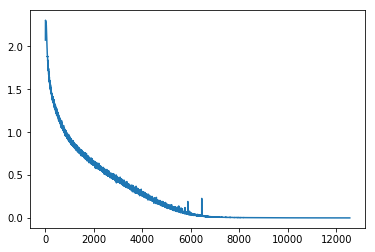

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images).cuda()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))